# Disaggregation

In [3]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/linalg/__init__.py:191: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-p

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _k_means
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._k_means_elkan import k_means_elkan
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchical
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._dbscan_inner import dbscan_inner


### Dividing data into train and test set

In [4]:
train = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')
test = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/__init__.py:90: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .utilsextension import (
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/file.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import hdf5extension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/link.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import linkextension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/table.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import tableextension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/index.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binar

Let us use building 1 for demo purposes

In [5]:
building = 1

Let's split data at April 30th

In [6]:
#train.set_window(end="30-4-2011")
#test.set_window(start="30-4-2011")

print(train.buildings.keys())
train_elec = train.buildings[2].elec
test_elec = test.buildings[2].elec

[1, 2, 3, 4, 5, 6]


/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=1)
  data = data.resample(**resample_kwargs)


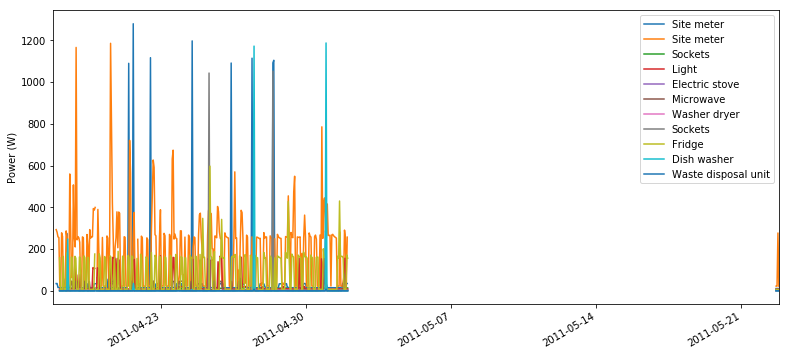

In [7]:
train_elec.plot()

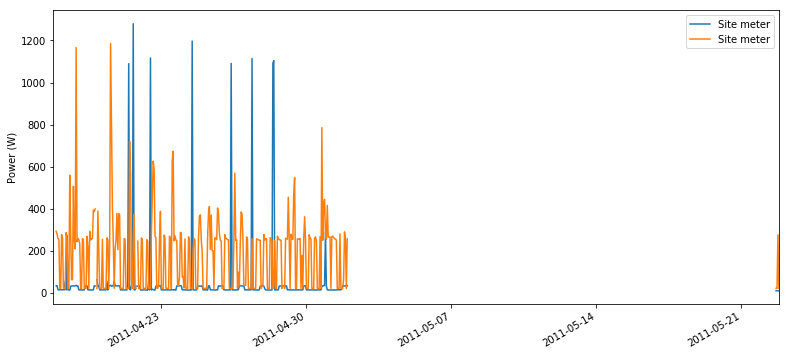

In [8]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [9]:
#fridge_meter = train_elec['fridge']

In [10]:
#fridge_df = fridge_meter.load().next()

In [11]:
#fridge_df.head()

In [12]:
mains = train_elec.mains()

In [13]:
mains_df = mains.load().next()

Loading data for meter ElecMeterID(instance=1, building=2, dataset='REDD')     

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/utils.py:336: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  return resampled.index[0]
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=30)
  data = data.resample(**resample_kwargs)


Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [14]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-17 19:18:27-04:00,306.809998
2011-04-17 19:18:28-04:00,306.319977
2011-04-17 19:18:29-04:00,306.400024
2011-04-17 19:18:30-04:00,305.760010
2011-04-17 19:18:31-04:00,321.360016


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [15]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/metergroup.py:1301: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  top_k_series.sort(ascending=asc)


In [16]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

### Training and disaggregation

#### FHMM

In [17]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)

fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Runtime = 14.4448299408 seconds.


In [18]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [19]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [20]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [21]:
local_timezone = train.metadata['timezone']

In [22]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [23]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [176]:
gt_overall.head()

,"ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])","ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])","ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])","ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])"
2011-04-18 01:32:00-04:00,8.0,4.0,3.0,0.0,7.0
2011-04-18 01:33:00-04:00,8.0,5.0,4.0,0.0,6.0
2011-04-18 01:34:00-04:00,8.0,4.0,4.0,0.0,7.0
2011-04-18 01:35:00-04:00,8.0,4.0,3.0,0.0,6.0
2011-04-18 01:36:00-04:00,8.0,5.0,3.0,0.0,6.0


Using prettier names!

In [24]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [25]:
pred_overall.head()

,Microwave,Light,Fridge,Dish washer,Sockets
2011-04-18 01:32:00-04:00,4.0,22.0,6.0,0.0,1.0
2011-04-18 01:33:00-04:00,4.0,22.0,6.0,0.0,1.0
2011-04-18 01:34:00-04:00,4.0,22.0,6.0,0.0,1.0
2011-04-18 01:35:00-04:00,4.0,22.0,6.0,0.0,1.0
2011-04-18 01:36:00-04:00,4.0,22.0,6.0,0.0,1.0


In [26]:
#pred_overall['Fridge'].head(1000).plot(label="Pred")
#gt_overall['Fridge'].head(1000).plot(label="GT")
#plt.legend()

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [29]:
pd.Series(rms_error)

Dish washer     97.653587
Fridge          80.176062
Light           58.145793
Microwave       67.317116
Sockets        169.988477
dtype: float64

In [32]:
import math
pd_ = {}
gt_ = {}
rerror = {}
lt = 0
leng = {}
napp = []
#print(gt_overall.columns)
for appliance in gt_overall.columns:
    t = len(pred_overall[appliance])
    if lt<t:
        lt = t
        napp = []
    if lt==t:
        napp.append(appliance)
    leng[appliance]= t
#     print(str(appliance) + " : "+str(t))
    

for appliance in napp:
    if (leng[appliance] < lt):
        continue
    print(appliance)
    gt_[appliance] = gt_overall[appliance]
    pd_[appliance] = pred_overall[appliance]
    #print(gt_[appliance])
    #for a,b in zip(pred_overall[appliance],gt_overall[appliance]):
    #    pd[appliance].append(a)
    #    gt[appliance].append(b)
   # print gt_[appliance][1]
    print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    #print(str(len(pred_overall[appliance]))+": "+str(len(gt_overall[appliance])))
    
print(napp)
#print(pd)


Microwave
20033, 20033
Light
20033, 20033
Fridge
20033, 20033
Dish washer
20033, 20033
Sockets
20033, 20033
['Microwave', 'Light', 'Fridge', 'Dish washer', 'Sockets']


In [30]:
print(lt)
s = 0
sd = 0
for i in range(lt):
    for appliance in napp:
        #if isinstance( pd[appliance][0], ( int, long ) ):
        #print( pd[appliance] )
        #print(i)
        s = s + abs(pd_[appliance][i]-gt_[appliance][i])
        sd = sd + gt_[appliance][i]
        
acc = 1 - (1.0*s)/sd/2
print(acc)

NameError: name 'lt' is not defined

In [ ]:
import math
pd = {}
gt = {}
rerror = {}
lt = 0
leng = {}
napp = []
for appliance in gt_overall.columns:
    t = len(gt_overall[appliance])
    if lt<t:
        lt = t
        napp = []
    if lt==t:
        napp.append(appliance)
    leng[appliance]= t
    

for appliance in napp:
    if (leng[appliance] < lt):
        continue
    pd[appliance] = []
    gt[appliance] = []
    for a,b in zip(pred_overall[appliance],gt_overall[appliance]):
        pd[appliance].append(a)
        gt[appliance].append(b)
    
    print(str(len(pd[appliance]))+", "+str(len(gt[appliance])))

#print(pd)
